In [ ]:
from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/content/gdrive')#force_remount=True
root_path = "/content/gdrive/My Drive/sims-projs-gdrive/cfd_unet_hennigh/"  #change dir to your project folder
#sys.path.append(os.path.abspath(root_path))
os.chdir(root_path)

#from google.colab import drive
#drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from pysim import config
from pysim import u_resnet_arch
import build_dataset
from tensorflow import keras
K = keras.backend
import pandas as pd
import argparse
#!python delme.py \
#--dataset="delme_test" - use to run python file with args

/content/gdrive/My Drive/datasets/cfd_hennigh/train /content/gdrive/My Drive/datasets/cfd_hennigh/val /content/gdrive/My Drive/datasets/cfd_hennigh/test
Original data: /content/gdrive/My Drive/datasets/cfd_hennigh
INFO: This data is saved as tf.records so no further processing is done on disk.
Folders /content/gdrive/My Drive/datasets/cfd_hennigh/train /content/gdrive/My Drive/datasets/cfd_hennigh/val /content/gdrive/My Drive/datasets/cfd_hennigh/test will not be created.
INFO: Further data processing is done on the fly.
Following file is processed: data.tfrecords
INFO: TFRecords file was parsed, and prepared for shuffling/batching!!!
INFO: There are 3012 samples in dataset!!!


In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, default="models/model.h5",
	help="path to trained model")
ap.add_argument("-r", "--restartmodel", type=bool, default=True,
	help="True if model is going to be restarted, False otherwise")
ap.add_argument("-e", "--epochs", type=int, default=5,
	help="training epochs")
ap.add_argument("-p", "--plot", type=str, default="plots/",
	help="path to output loss/accuracy plot...current history")
args = vars(ap.parse_args([]))

RESTART_MODEL = args["restartmodel"]
NUM_EPOCHS = args["epochs"]

In [ ]:
train_dataset = build_dataset.train_dataset
val_dataset   = build_dataset.val_dataset
test_dataset  = build_dataset.test_dataset

In [ ]:
model = u_resnet_arch.model
optimizer = tf.keras.optimizers.SGD()
model.compile(loss = "mean_squared_error", optimizer = optimizer)
#model.summary()
#tf.keras.utils.plot_model(model, to_file="u_resnet_arch.png",
#    show_shapes=True,show_layer_names=True,
#    rankdir="TB", expand_nested=True, dpi=96)

In [ ]:
#find suitable learning rate

K = keras.backend
#from tensorflow.keras.callbacks import Callback

class showLR(keras.callbacks.Callback) :
    def on_batch_begin(self, epoch, logs=None):
        lr = float(K.get_value(self.model.optimizer.lr))
        print (" epoch={:02d}, lr={:.5f}".format( epoch, lr ))
        return lr

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        #print("factor", self.factor)

def learning_rate_finder(model, train_dataset, epochs=1, batch_size=12, min_rate=10**-2, max_rate=10):
    init_weights = model.get_weights()
    stepsPerEpoch = 64
    #numBatchUpdates = epochs * stepsPerEpoch
    iterations =  3000 /(stepsPerEpoch)
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    print(factor)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(train_dataset, epochs=epochs, steps_per_epoch = 64,
                        callbacks=[exp_lr, showLR()])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), max(losses)])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    #plt.text(0.05, 700, "use turning_point/10 to select initial learning rate")
    plt.show()
rates, losses = learning_rate_finder(model, train_dataset, epochs = 1, batch_size = 12,
                                            min_rate=0.1, max_rate=3)

1.0752561125918547
 epoch=00, lr=0.10000
 1/64 [..............................] - ETA: 53s - loss: 0.3054factor 1.0752561125918547
 epoch=01, lr=0.10753
 2/64 [..............................] - ETA: 5s - loss: 0.2815 factor 1.0752561125918547
 epoch=02, lr=0.11562
 3/64 [>.............................] - ETA: 4s - loss: 0.2642factor 1.0752561125918547
 epoch=03, lr=0.12432
 4/64 [>.............................] - ETA: 4s - loss: 0.2477factor 1.0752561125918547
 epoch=04, lr=0.13367
 5/64 [=>............................] - ETA: 4s - loss: 0.2340factor 1.0752561125918547
 epoch=05, lr=0.14373
 6/64 [=>............................] - ETA: 4s - loss: 0.2212factor 1.0752561125918547
 epoch=06, lr=0.15455
 7/64 [==>...........................] - ETA: 3s - loss: 0.2089factor 1.0752561125918547
 epoch=07, lr=0.16618
 8/64 [==>...........................] - ETA: 3s - loss: 0.1973factor 1.0752561125918547
 epoch=08, lr=0.17869
 9/64 [===>..........................] - ETA: 3s - loss: 0.1867factor

In [ ]:
https://www.jeremyjordan.me/nn-learning-rate/

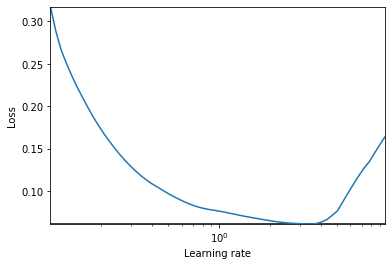

In [ ]:
plot_lr_vs_loss(rates, losses)

In [ ]:
class showLR(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs = None):
     lr = float(K.get_value(self.model.optimizer.lr))
     print("epoch={:02d}, lr = {:.5f}".format(epoch, lr))
     return lr

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 5:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))
            
checkpoint_filepath = os.path.sep.join(["models", "checkpoints"])
#os.mkdir(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,\
                            monitor='val_loss', mode='min', save_best_only=True)
  
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.8, patience = 10),
             tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 300, restore_best_weights = True), showLR()]          

In [ ]:
if (RESTART_MODEL == TRUE):
    print("INFO : Model", args["model"], "is going to be restarted and continued for", args["epochs"], "epochs...")
    print("INFO : Model", args["model"], "is going to be overwritten")
    model = keras.models.load_model("model.h5") 
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    #K.set_value(model.optimizer.lr, 5e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))
    history = model.fit(train_dataset, validation_data = val_dataset, epochs = NUM_EPOCHS,\
              steps_per_epoch = 12, validation_steps = 4,\
              callbacks = callbacks)  
else:
    optimizer = tf.keras.optimizers.Nadam(lr = 0.01)
    model.compile(loss = "mean_squared_error", optimizer = optimizer)
    history = model.fit(train_dataset, validation_data = val_dataset,epochs = NUM_EPOCHS, \
         steps_per_epoch = 64, validation_steps = 4)
model.save(args["model"])

[INFO] old learning rate: 2.0769189177372027e-06
[INFO] new learning rate: 2.0769189177372027e-06
Epoch 1/3
epoch=00, lr = 0.00000
12/12 [==============================] - 52s 4s/step - loss: 2.4075e-06 - val_loss: 2.1335e-06
Epoch 2/3
epoch=01, lr = 0.00000
12/12 [==============================] - 38s 3s/step - loss: 2.6700e-06 - val_loss: 2.1593e-06
Epoch 3/3
epoch=02, lr = 0.00000
12/12 [==============================] - 37s 3s/step - loss: 2.3538e-06 - val_loss: 2.3793e-06


In [ ]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = os.path.join(args["plots"], "all_history.csv")
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

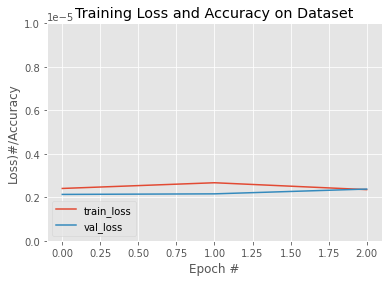

In [ ]:
# plot training and validation accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylim(0.0, 1e-5)
plt.ylabel("Loss)#/Accuracy")
plt.legend(loc="lower left")
history_history = os.path.join(args["plots"], "history_history.png")
plt.savefig(history_history)